<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico 1 : Propiedades en Venta
## Grupo 13
### Integrantes:
- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez 
- Lautaro Barrionuevo
- Nicolás Carreño

# Importe de librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler

import geopandas
from shapely.geometry import Point
import osmnx as ox
import xgboost as xgb
import sklearn

# Lectura de archivo

In [3]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [4]:
ds_propiedades.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

# Análisis Exploratorio y Preprocesamiento de Dato

***Filtrado inicial***

Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [5]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)]  #Preguntar si el na va en true

***Exploración inicial***

Tipo de variable

In [6]:
ds_prop_filtrado.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas

In [7]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_prop_filtrado.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

media       mediana            q1  \
latitud                      -34.591481     -34.59579    -34.615975   
longitud                     -58.449795     -58.43900    -58.466522   
property_rooms                 2.822799       3.00000      2.000000   
property_bedrooms              2.014629       2.00000      1.000000   
property_surface_total       109.092970      65.00000     45.000000   
property_surface_covered      87.931932      58.00000     40.000000   
property_price            226238.207185  143900.00000  95000.000000   

                                     q3           moda  
latitud                      -34.577413     -34.541250  
longitud                     -58.408862     -58.472966  
property_rooms                 4.000000       3.000000  
property_bedrooms              3.000000       1.000000  
property_surface_total       105.000000      50.000000  
property_surface_covered      88.000000      40.000000  
property_price            237000.000000  110000.000000

Variables Cualitativas

In [8]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_prop_filtrado.loc[:,cualitativos]

* Mostrar cantidad de valores posibles

In [9]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       55704
dtype: int64

* Mostrar frecuencias
    * Obviamos las opciones de un solo tipo porque la frecuencia es de 100%

In [10]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.248529
Belgrano                 9.482906
Caballito                7.639185
Recoleta                 6.694944
Villa Urquiza            4.980177
Almagro                  4.349263
Nuñez                    3.779095
Villa Crespo             3.398627
Flores                   3.314434
Barrio Norte             3.170560
Balvanera                2.720820
Colegiales               2.079248
Villa Devoto             2.047276
Villa del Parque         1.949228
Saavedra                 1.949228
Puerto Madero            1.591142
San Telmo                1.470714
San Cristobal            1.385455
San Nicolás              1.380126
Retiro                   1.332168
Barracas                 1.327905
Boedo                    1.318314
Floresta                 1.273553
Monserrat                1.188294
Parque Chacabuco         1.143533
Villa Pueyrredón         1.077458
Coghlan                  1.048683
Villa Luro               0.774789
Mataderos                0.766263
Chacarita     

In [11]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.761122
PH               9.831404
Casa             4.407474
Name: property_type, dtype: float64

In [12]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                  1.557576
Departamento - Recoleta                                                                                 1.404789
Departamento - Belgrano                                                                                 1.180914
Departamento - Caballito                                                                                0.993114
Departamento - Almagro                                                                                  0.706639
                                                                                                          ...   
Gran 3 ambientes en pleno Villa del Parque                                                              0.001061
Venta PH 3 Amb Con Patio Flores                                                                         0.001061
Venta, PH, 3 Ambientes, PB, Quincho, Parrilla, Terraza, Paternal                                

* Determinar variables irrelevantes en el análisis

Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. Tambien la caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. Por ultimo, los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas. 

In [13]:
columnas_a_eliminar = ["id","place_l5","place_l6"] # variables irrelevantes, podrian ser: property_title place_l5	place_l6 y (start_date created_on) son lo mismo
ds_filtado_copia = ds_prop_filtrado.copy()
ds_filtado_copia.drop(columns = columnas_a_eliminar, inplace = True)

Duplicados

In [14]:
ds_filtado_copia.duplicated

<bound method DataFrame.duplicated of         start_date    end_date  created_on    latitud   longitud  \
25      2021-09-09  2021-09-26  2021-09-09        NaN        NaN   
42      2021-09-09  2021-09-26  2021-09-09 -34.637319 -58.361124   
43      2021-09-09  2021-09-28  2021-09-09 -34.628647 -58.361871   
49      2021-09-09  2022-01-05  2021-09-09 -34.610027 -58.401934   
51      2021-09-09  2022-03-09  2021-09-09 -34.631621 -58.416825   
...            ...         ...         ...        ...        ...   
460072  2021-01-05  2022-09-02  2021-01-05 -34.603245 -58.489810   
460073  2021-01-05  2021-02-17  2021-01-05 -34.614063 -58.482814   
460074  2021-01-05  2021-01-27  2021-01-05 -34.614175 -58.479062   
460075  2021-01-05  2021-01-27  2021-01-05 -34.614175 -58.479062   
460090  2021-01-05  2021-01-08  2021-01-05 -34.599790 -58.373411   

               place_l2              place_l3 place_l4 operation  \
25      Capital Federal                   NaN      NaN     Venta   
42      C

* Realizar un análisis gráfico de las distribuciones de las variables

In [15]:

#sns.pairplot(ds_filtado_copia)

###Correlaciones existentes entre las variables




*   Analizar las correlaciones existentes entre las variables.



In [16]:
ds_prop_filtrado.corr()

C:\Users\Carreño\AppData\Local\Temp\ipykernel_6088\1687440363.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_prop_filtrado.corr()


latitud  longitud  place_l6  property_rooms  \
latitud                   1.000000 -0.239235       NaN        0.005521   
longitud                 -0.239235  1.000000       NaN       -0.008324   
place_l6                       NaN       NaN       NaN             NaN   
property_rooms            0.005521 -0.008324       NaN        1.000000   
property_bedrooms         0.003162 -0.008556       NaN        0.871940   
property_surface_total    0.025348 -0.015056       NaN        0.067211   
property_surface_covered  0.002352 -0.001155       NaN        0.076097   
property_price            0.016635  0.023314       NaN        0.488934   

                          property_bedrooms  property_surface_total  \
latitud                            0.003162                0.025348   
longitud                          -0.008556               -0.015056   
place_l6                                NaN                     NaN   
property_rooms                     0.871940                0.067211   
property_bedrooms                  1.000000                0.067702   
property_surface_total             0.067702                1.000000   
property_surface_covered           0.075075                0.604311   
property_price                     0.425386                0.085235   

                          property_surface_covered  property_price  
latitud                                   0.002352        0.016635  
longitud                                 -0.001155        0.023314  
place_l6                                       NaN             NaN  
property_rooms                            0.076097        0.488934  
property_bedrooms                         0.075075        0.425386  
property_surface_total                    0.604311        0.085235  
property_surface_covered                  1.000000        0.056238  
property_price                            0.056238        1.000000

Precio promedio de propiedad por Barrio

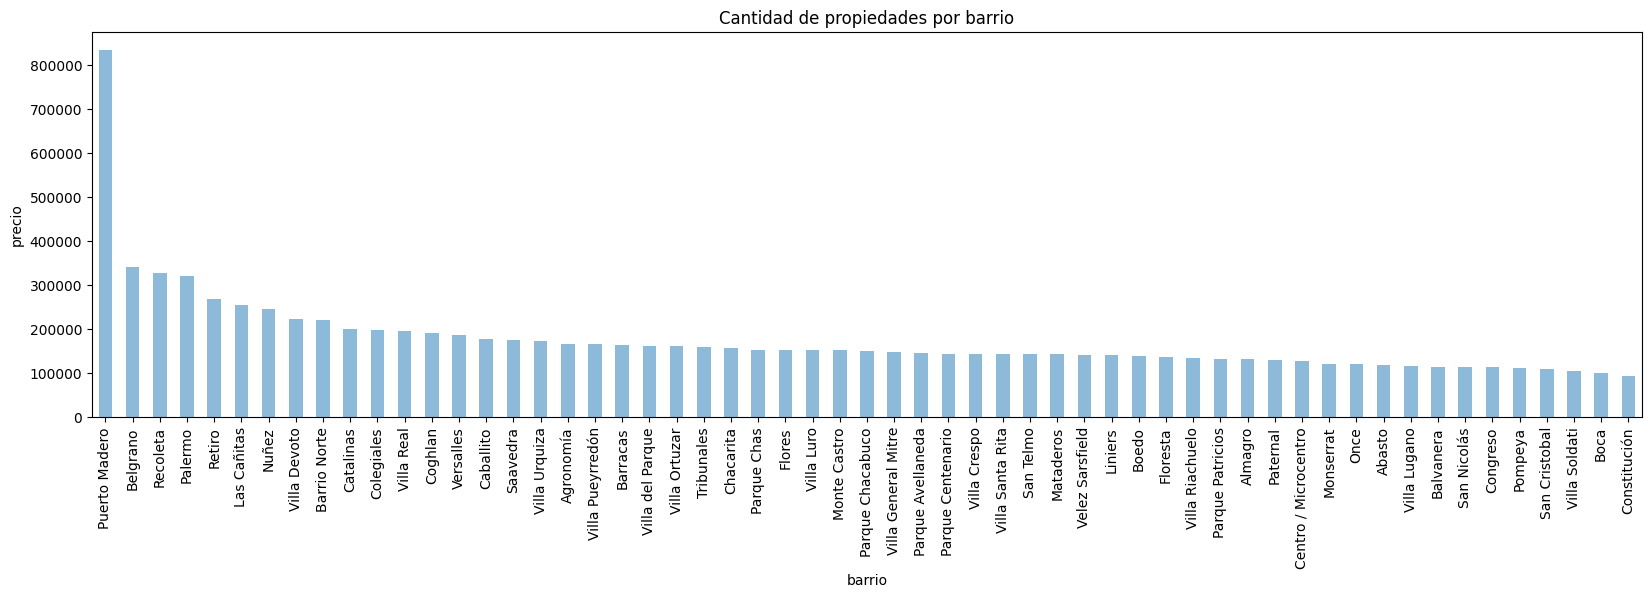

In [17]:
ds_precio_prom = ds_prop_filtrado.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Cantidad de propiedades por barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

# Datos faltantes

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset

In [18]:
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


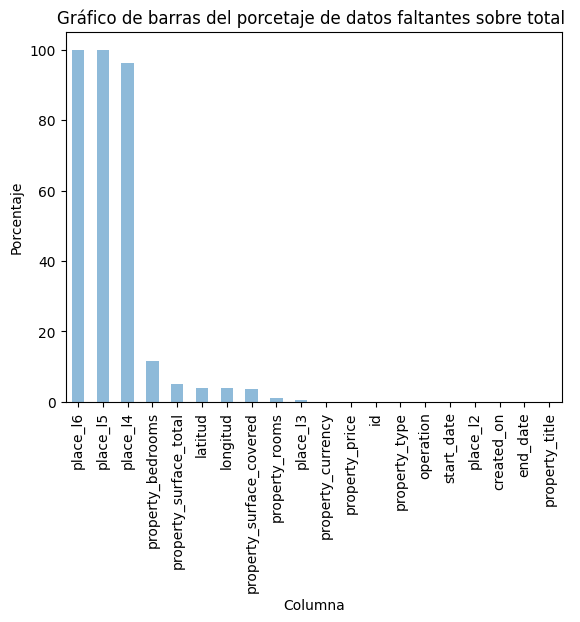

In [19]:
ds_porcentaje = ds_prop_filtrado.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Nos fijamos si hay algun valor sospechoso que sea negativo

In [20]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_prop_filtrado[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
property_price                    False
property_surface_total            False
property_surface_covered          False
property_rooms                    False
property_bedrooms                  True

Property_bedrooms tiene numero negativo, asi que veo cuantos hay

In [21]:
ds_prop_filtrado[ds_prop_filtrado['property_bedrooms'] < 1]

id  start_date    end_date  created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18  2021-01-07   

          latitud   longitud         place_l2       place_l3 place_l4  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
406880      NaN       NaN     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880               -1.0                    61.0                      43.0   

        property_price property_currency  \
406880        125000.0               USD   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

Solo hay uno asi que se lo coloca en nan porque no condiciona el analisis pero si el dato es incorrecto

In [22]:
ds_prop_filtrado.loc[ds_prop_filtrado['property_bedrooms'] < 1,'property_bedrooms'] = np.nan
ds_prop_filtrado[ds_prop_filtrado['id'] == '3WI+zCCMeb9TR5kOBm7rhg==']

id  start_date    end_date  created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18  2021-01-07   

          latitud   longitud         place_l2       place_l3 place_l4  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
406880      NaN       NaN     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880                NaN                    61.0                      43.0   

        property_price property_currency  \
406880        125000.0               USD   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.

In [23]:
columnas_a_eliminar = ["place_l4","place_l5","place_l6","id"]
ds_prop_filtrado.drop(columns = columnas_a_eliminar, inplace = True)

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.

In [24]:
filas_cantidad_nan = pd.DataFrame(ds_prop_filtrado).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 21387 lineas que poseen uno o mas valores faltantes


Verificamos que no haya duplicados y las eliminamos

In [25]:
print(ds_prop_filtrado[ds_prop_filtrado.duplicated(keep=False)])
ds_prop_filtrado = ds_prop_filtrado.drop_duplicates()

        start_date    end_date  created_on    latitud   longitud  \
1093    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1094    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1095    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1096    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1239    2021-09-09  2022-02-09  2021-09-09 -34.580818 -58.491051   
...            ...         ...         ...        ...        ...   
459606  2021-01-05  2021-01-10  2021-01-05 -34.555751 -58.463942   
459953  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459959  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459961  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   
459962  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   

               place_l2       place_l3 operation property_type  \
1093    Capital Federal   Barrio Norte     Venta  Departamento   
1094    Capital Federal   Barrio Norte     Venta  D

*Determinar, de ser posible, estrategias para reparar los valores faltantes.*

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios

In [26]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

for index, registro_prop in ds_prop_filtrado.iterrows():
    if  type(registro_prop["place_l3"]) is str:
        continue
    for index_, registro_barrio in ds_barrios.iterrows():
        if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
            barrio_aux = registro_barrio['BARRIO']
            ds_prop_filtrado.loc[index, 'place_l3'] = barrio_aux

Me fijo si quedo algun place_l3 incompleto.

In [27]:
ds_prop_filtrado[ds_prop_filtrado["place_l3"].isna()]

start_date    end_date  created_on  latitud  longitud  \
25      2021-09-09  2021-09-26  2021-09-09      NaN       NaN   
3088    2021-02-20  2022-02-09  2021-02-20 -31.6789 -63.87964   
3099    2021-02-20  2021-03-01  2021-02-20      NaN       NaN   
5942    2021-10-29  2022-01-08  2021-10-29      NaN       NaN   
6699    2021-02-09  2021-06-05  2021-02-09      NaN       NaN   
...            ...         ...         ...      ...       ...   
458690  2021-01-05  2021-03-01  2021-01-05      NaN       NaN   
458696  2021-01-05  2021-03-01  2021-01-05      NaN       NaN   
459187  2021-01-05  2021-03-01  2021-01-05      NaN       NaN   
459195  2021-01-05  2021-03-01  2021-01-05      NaN       NaN   
459199  2021-01-05  2021-03-01  2021-01-05      NaN       NaN   

               place_l2 place_l3 operation property_type  property_rooms  \
25      Capital Federal      NaN     Venta          Casa             4.0   
3088    Capital Federal      NaN     Venta          Casa             5.0   
3099    Capital Federal      NaN     Venta          Casa             3.0   
5942    Capital Federal      NaN     Venta  Departamento             3.0   
6699    Capital Federal      NaN     Venta          Casa             NaN   
...                 ...      ...       ...           ...             ...   
458690  Capital Federal      NaN     Venta          Casa             NaN   
458696  Capital Federal      NaN     Venta          Casa             NaN   
459187  Capital Federal      NaN     Venta  Departamento             2.0   
459195  Capital Federal      NaN     Venta  Departamento             2.0   
459199  Capital Federal      NaN     Venta  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
25                    3.0                   171.0                     133.0   
3088                  4.0                   220.0                     220.0   
3099                  2.0                    69.0                      53.0   
5942                  2.0                    87.0                      87.0   
6699                  3.0                     NaN                     390.0   
...                   ...                     ...                       ...   
458690                2.0                     NaN                      80.0   
458696                2.0                    60.0                      60.0   
459187                1.0                    41.0                      41.0   
459195                1.0                    44.0                      44.0   
459199                2.0                    70.0                      70.0   

        property_price property_currency  \
25            210000.0               USD   
3088          230000.0               USD   
3099           54600.0               USD   
5942          117000.0               USD   
6699          795000.0               USD   
...                ...               ...   
458690        120000.0               USD   
458696         75000.0               USD   
459187         75000.0               USD   
459195        128000.0               USD   
459199        155000.0               USD   

                                           property_title  
25            VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
3088    VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN    
3099    Venta Duplex 3 amb. Complejo Quimaral I - San ...  
5942    impecable 3 Ambientes de 88 m2!!!! con 2 baños...  
6699    Magnífica casa a la venta de 7 ambientes en Ab...  
...                                                   ...  
458690               Casa a reciclar 3 Amb. en San Martin  
458696                       CASA 3 AMBIENTES CON TERRAZA  
459187        San Martín. Centro  depto 2 amb a estrenar.  
459195  San Martin Ctro. s/ San Lorenzo Impecable Dpto...  
459199  San Martin Ctro. Semipiso 3 Amb. amplios,coche...  

[363 rows x 16 columns]

Eliminamos aquellas que no tengan place_l3 porque no se pueden completar por el barrio o tienen mal el dato ej dato con latitud -31.678 y longitud -63.87964 pertenece a Cordoba pero place_l2 es Capital federal por lo que puede ser que el dato este subido erroneamente y tambien eliminamos los registus sin latidu ni longitu porque no es posible saber su dato exacto y puede ser un regiistro mal cargado. Y vemos cuantos datos faltantes quedan.

In [28]:
ds_prop_filtrado = ds_prop_filtrado[~ds_prop_filtrado["place_l3"].isna() & ~ds_prop_filtrado["latitud"].isna() & ~ds_prop_filtrado["longitud"].isna()]
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.000000
operation                    0.000000
property_type                0.000000
property_rooms               0.959856
property_bedrooms           11.517156
property_surface_total       5.031397
property_surface_covered     3.544517
property_price               0.000000
property_currency            0.000000
property_title               0.000000
dtype: float64


Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.

In [29]:
copia_pre_imputacion= ds_prop_filtrado.copy()
mice = ds_prop_filtrado.copy()
#mice= mice[~mice["latitud"].isna() & ~mice["place_l3"].isna()]
columnas=['property_surface_total','property_surface_covered','property_rooms','property_bedrooms'] #,'property_surface_covered','property_bathrooms','property_rooms','property_price'
df_eliminar_nans_op3=ds_prop_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean", min_value=0) #imputation_order='roman'
df_eliminar_nans_op3_completo=imp.fit_transform(df_eliminar_nans_op3)
mice['property_surface_total']= df_eliminar_nans_op3_completo[:,0]
mice['property_surface_covered']=df_eliminar_nans_op3_completo[:, 1]
mice['property_rooms']= df_eliminar_nans_op3_completo[:, 2]
#mice['property_price']= df_eliminar_nans_op3_completo[:, 3]
mice['property_bedrooms'] = df_eliminar_nans_op3_completo[:,3]
#mice['latitud'] = df_eliminar_nans_op3_completo[:,5]
#mice['longitud'] = df_eliminar_nans_op3_completo[:,6]
#mice['latitud'].drop()
#mice['longitud'].drop()
mice=mice.round(decimals = 4)


In [30]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
property_currency           0.0
property_title              0.0
dtype: float64


Chequeamos que la imputacion no haya creado datos erroneos negativos

In [31]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(mice[columnas_con_numeros] < 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
property_price                    False
property_surface_total            False
property_surface_covered          False
property_rooms                    False
property_bedrooms                 False

In [32]:
mice[mice['property_surface_covered']==0]

start_date    end_date  created_on  latitud  longitud  \
2773    2021-12-17  2022-01-27  2021-12-17 -34.5924  -58.3963   
10828   2021-01-13  2021-09-14  2021-01-13 -34.6019  -58.4113   
60741   2021-07-18  2021-08-02  2021-07-18 -34.6028  -58.3972   
95129   2021-09-24  2021-12-10  2021-09-24 -34.6036  -58.3768   
106084  2021-03-11  2021-06-05  2021-03-11 -34.6178  -58.3794   
137881  2021-01-22  2021-06-05  2021-01-22 -34.6036  -58.3768   
139662  2021-07-15  2021-08-24  2021-07-15 -34.5925  -58.3953   
153464  2021-12-09  2021-12-15  2021-12-09 -34.6036  -58.3768   
306760  2021-03-04  2021-06-05  2021-03-04 -34.6008  -58.3899   
328146  2021-12-14  2022-01-19  2021-12-14 -34.6036  -58.3768   
370036  2021-11-08  2022-01-27  2021-11-08 -34.6166  -58.4088   
370277  2021-11-08  2022-01-27  2021-11-08 -34.6166  -58.4088   
406030  2021-01-07  9999-12-31  2021-01-07 -34.6336  -58.4229   
406032  2021-01-07  2022-08-03  2021-01-07 -34.6267  -58.4234   
413890  2021-10-26  2022-01-27  2021-10-26 -34.6055  -58.4077   
415512  2021-09-08  2022-03-09  2021-09-08 -34.6028  -58.3972   
441137  2021-07-20  2021-09-24  2021-07-20 -34.6036  -58.3768   

               place_l2      place_l3 operation property_type  property_rooms  \
2773    Capital Federal  Barrio Norte     Venta  Departamento             1.0   
10828   Capital Federal        Abasto     Venta  Departamento             1.0   
60741   Capital Federal     Balvanera     Venta  Departamento             1.0   
95129   Capital Federal   San Nicolás     Venta  Departamento             1.0   
106084  Capital Federal     San Telmo     Venta  Departamento             1.0   
137881  Capital Federal   San Nicolás     Venta  Departamento             1.0   
139662  Capital Federal  Barrio Norte     Venta  Departamento             1.0   
153464  Capital Federal   San Nicolás     Venta  Departamento             1.0   
306760  Capital Federal   San Nicolás     Venta  Departamento             1.0   
328146  Capital Federal   San Nicolás     Venta  Departamento             1.0   
370036  Capital Federal       Almagro     Venta  Departamento             1.0   
370277  Capital Federal     Balvanera     Venta  Departamento             1.0   
406030  Capital Federal         Boedo     Venta  Departamento             1.0   
406032  Capital Federal         Boedo     Venta  Departamento             1.0   
413890  Capital Federal     Balvanera     Venta  Departamento             1.0   
415512  Capital Federal     Balvanera     Venta  Departamento             1.0   
441137  Capital Federal   San Nicolás     Venta  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
2773               0.5221                    20.0                       0.0   
10828              1.0000                    18.0                       0.0   
60741              0.5221                    18.0                       0.0   
95129              0.5221                    20.0                       0.0   
106084             0.5221                    20.0                       0.0   
137881             0.5221                    20.0                       0.0   
139662             0.5221                    20.0                       0.0   
153464             0.5221                    20.0                       0.0   
306760             0.5221                    20.0                       0.0   
328146             0.5221                    20.0                       0.0   
370036             0.5221                    20.0                       0.0   
370277             0.5221                    20.0                       0.0   
406030             0.5221                    20.0                       0.0   
406032             0.5221                    19.0                       0.0   
413890             0.5221                    19.0                       0.0   
415512             0.5221                    18.0                       0.0   
441137             0.5221          

En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

***Comparamos property price sin y con imputacion***

<AxesSubplot: ylabel='property_price'>

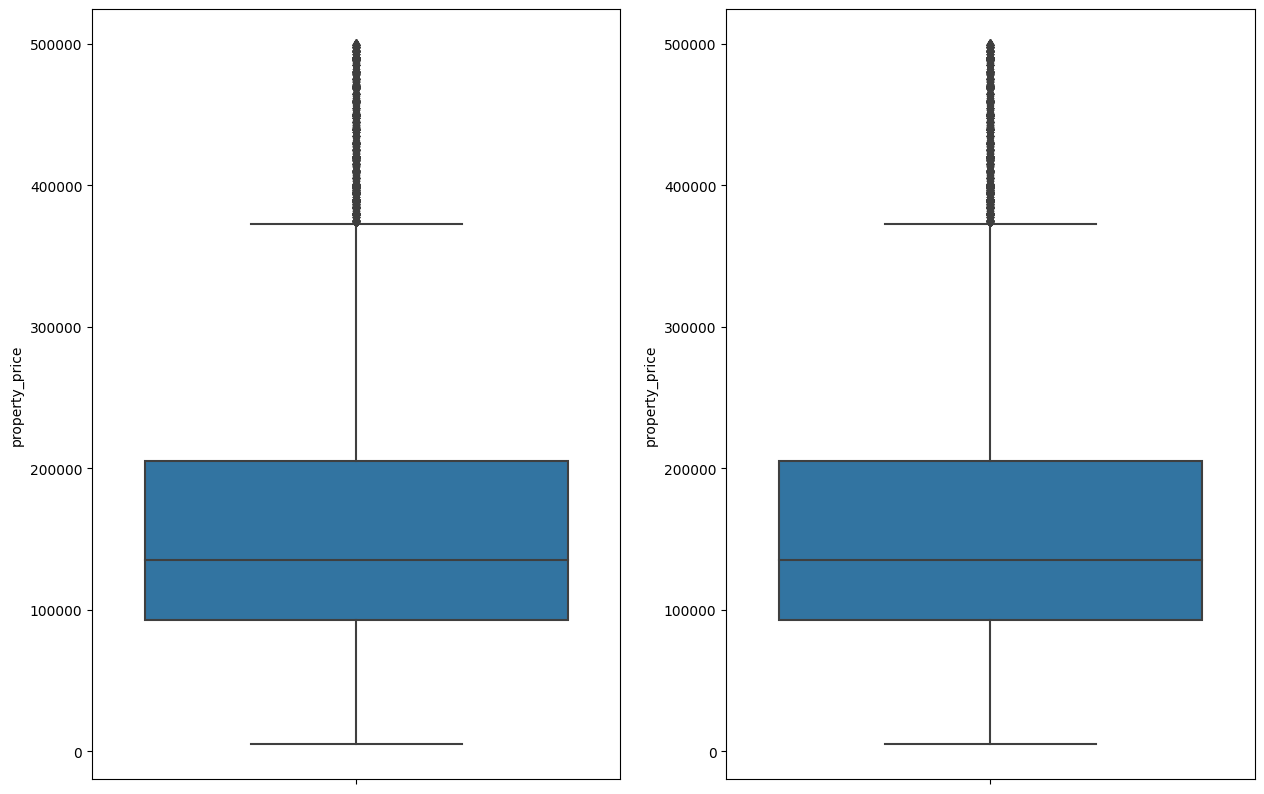

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_price", data=copia_pre_imputacion[copia_pre_imputacion["property_price"]<500000], ax=axes[0])
sns.boxplot(y="property_price", data=mice[mice["property_price"]<500000], ax=axes[1])

***Comparamos property bedrooms***

<AxesSubplot: >

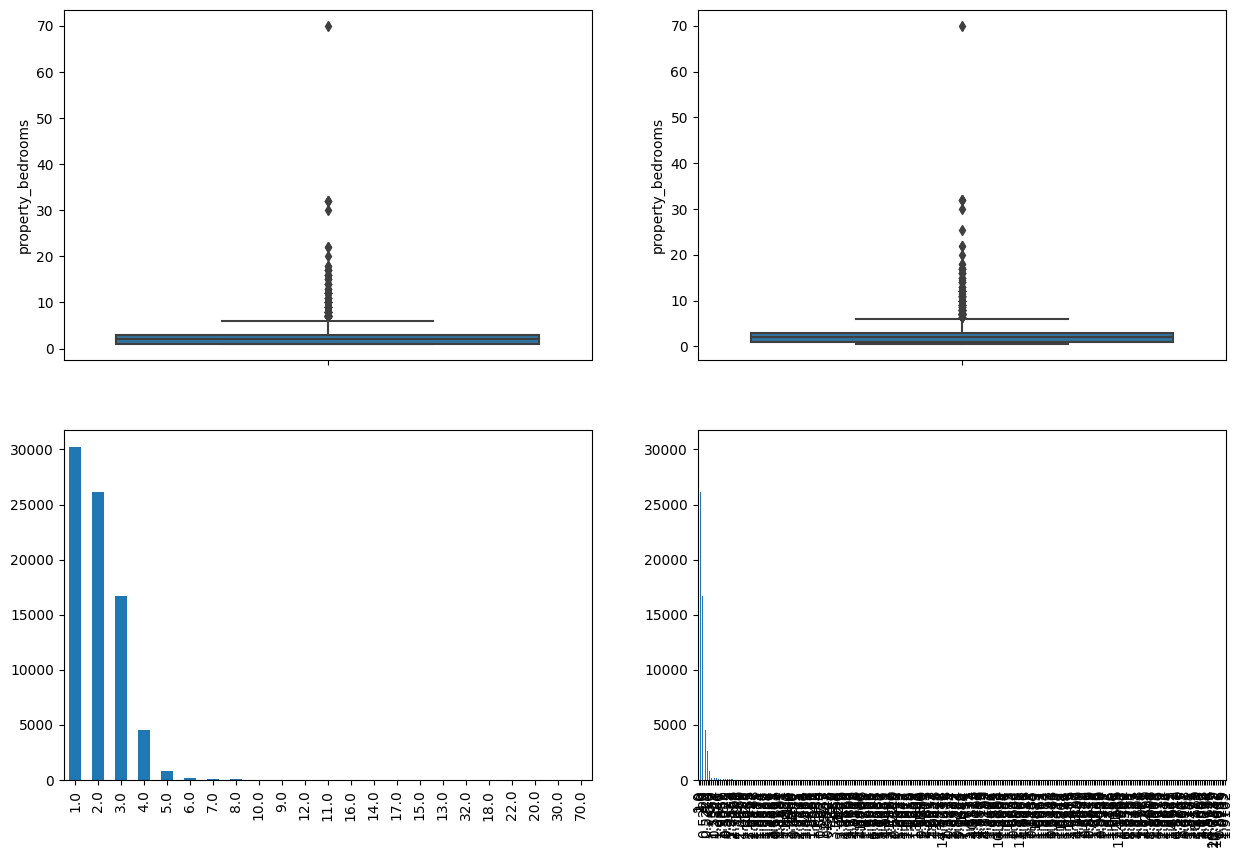

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=copia_pre_imputacion, ax=axes[0,0])
sns.boxplot(y="property_bedrooms", data=mice, ax=axes[0,1])
copia_pre_imputacion["property_bedrooms"].value_counts().plot.bar(ax=axes[1,0])
mice["property_bedrooms"].value_counts().plot.bar(ax=axes[1,1])

El grafico nos muestra que la mayoria de los valores faltantes se complentan co una sola habitacion

In [35]:
mice[mice.duplicated(keep=False)]

start_date    end_date  created_on  latitud  longitud  \
89489   2021-05-14  2021-06-05  2021-05-14 -34.5969  -58.3838   
89491   2021-05-14  2021-06-05  2021-05-14 -34.5969  -58.3838   
203772  2021-05-10  2021-06-05  2021-05-10 -34.5775  -58.4391   
203806  2021-05-10  2021-06-05  2021-05-10 -34.5775  -58.4391   
268256  2021-07-09  9999-12-31  2021-07-09 -34.5793  -58.4544   
268261  2021-07-09  9999-12-31  2021-07-09 -34.5793  -58.4544   
336381  2021-07-21  2022-07-07  2021-07-21 -34.5792  -58.4544   
336384  2021-07-21  2022-07-07  2021-07-21 -34.5792  -58.4544   
422039  2021-07-07  2021-08-01  2021-07-07 -34.6155  -58.4244   
422043  2021-07-07  2021-08-01  2021-07-07 -34.6155  -58.4244   

               place_l2    place_l3 operation property_type  property_rooms  \
89489   Capital Federal    Recoleta     Venta  Departamento         10.0000   
89491   Capital Federal    Recoleta     Venta  Departamento         10.0000   
203772  Capital Federal     Palermo     Venta  Departamento          1.0000   
203806  Capital Federal     Palermo     Venta  Departamento          1.0000   
268256  Capital Federal  Colegiales     Venta  Departamento          2.0000   
268261  Capital Federal  Colegiales     Venta  Departamento          2.0000   
336381  Capital Federal  Colegiales     Venta  Departamento          1.8769   
336384  Capital Federal  Colegiales     Venta  Departamento          1.8769   
422039  Capital Federal     Almagro     Venta  Departamento          1.0000   
422043  Capital Federal     Almagro     Venta  Departamento          1.0000   

        property_bedrooms  property_surface_total  property_surface_covered  \
89489              6.0000                   388.0                     311.0   
89491              6.0000                   388.0                     311.0   
203772             0.5223                    40.0                      40.0   
203806             0.5223                    40.0                      40.0   
268256             1.0000                    51.0                      51.0   
268261             1.0000                    51.0                      51.0   
336381             1.0000                    27.0                      27.0   
336384             1.0000                    27.0                      27.0   
422039             0.5222                    36.0                      33.0   
422043             0.5222                    36.0                      33.0   

        property_price property_currency  \
89489         650000.0               USD   
89491         650000.0               USD   
203772        180000.0               USD   
203806        180000.0               USD   
268256        132600.0               USD   
268261        132600.0               USD   
336381         63000.0               USD   
336384         63000.0               USD   
422039         76000.0               USD   
422043         76000.0               USD   

                                           property_title  
89489   Excelente departamento Francés frente a Plaza ...  
89491   Excelente departamento Francés frente a Plaza ...  
203772                             Departamento - Palermo  
203806                             Departamento - Palermo  
268256                          Departamento - Colegiales  
268261                          Departamento - Colegiales  
336381                          Departamento - Colegiales  
336384                          Departamento - Colegiales  
422039   Departamento a estrenar - Almagro - Monoambiente  
422043   Departamento a estrenar - Almagro - Monoambiente

# Analizar la existencia de valores atípicos


### Detectar valores atípicos en los datos en forma univariada

Preparamos el dataset

In [36]:
ds_atipicos = mice.copy()
ds_atipicos_copia = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

Analizamos property_rooms

In [37]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"

In [38]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
58                10.0               10.0                   394.0   
834                9.0                4.0                   390.0   
1040               8.0                6.0                   201.0   
1108               8.0                6.0                   201.0   
1349               8.0                6.0                   201.0   
...                ...                ...                     ...   
459306             8.0                4.0                   225.0   
459724             8.0                3.0                   285.0   
459755             8.0                5.0                   431.0   
459764             8.0                4.0                   383.0   
459922            10.0                9.0                   145.0   

        property_surface_covered  property_price   z_rooms  zm_rooms  
58                         244.0        500000.0  5.023524    4.7215  
834                        340.0       1200000.0  4.322762    4.0470  
1040                       201.0        345000.0  3.622001    3.3725  
1108                       201.0        345000.0  3.622001    3.3725  
1349                       201.0        345000.0  3.622001    3.3725  
...                          ...             ...       ...       ...  
459306                     225.0        740000.0  3.622001    3.3725  
459724                     272.0       1250000.0  3.622001    3.3725  
459755                     415.0       2800000.0  3.622001    3.3725  
459764                     383.0       1700000.0  3.622001    3.3725  
459922                     145.0        300000.0  5.023524    4.7215  

[754 rows x 7 columns]

In [39]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

Empty DataFrame
Columns: [property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms]
Index: []

Grafico Boxplot

<AxesSubplot: ylabel='property_rooms'>

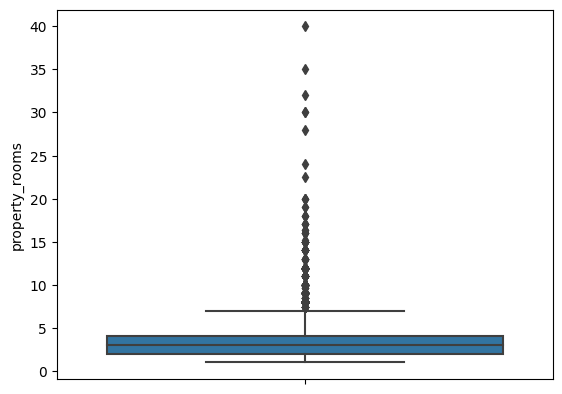

In [40]:
sns.boxplot(y=ds_atipicos.property_rooms)

Anlalizamos property_bedrooms

In [41]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers

In [42]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
58                10.0               10.0                   394.0   
1040               8.0                6.0                   201.0   
1108               8.0                6.0                   201.0   
1349               8.0                6.0                   201.0   
1363               8.0                6.0                   201.0   
...                ...                ...                     ...   
457366             7.0                6.0                   280.0   
457782            10.0                6.0                   520.0   
458670             5.0                6.0                   125.0   
458873            12.0               12.0                   820.0   
459922            10.0                9.0                   145.0   

        property_surface_covered  property_price   z_rooms  zm_rooms  \
58                         244.0        500000.0  5.023524    4.7215   
1040                       201.0        345000.0  3.622001    3.3725   
1108                       201.0        345000.0  3.622001    3.3725   
1349                       201.0        345000.0  3.622001    3.3725   
1363                       201.0        345000.0  3.622001    3.3725   
...                          ...             ...       ...       ...   
457366                     230.0        426000.0  2.921240    2.6980   
457782                     500.0       3300000.0  5.023524    4.7215   
458670                     100.0        265000.0  1.519717    1.3490   
458873                     820.0        550000.0  6.425046    6.0705   
459922                     145.0        300000.0  5.023524    4.7215   

        z_bedrooms  zm_bedrooms  
58        7.014047       5.3960  
1040      3.566507       2.6980  
1108      3.566507       2.6980  
1349      3.566507       2.6980  
1363      3.566507       2.6980  
...            ...          ...  
457366    3.566507       2.6980  
457782    3.566507       2.6980  
458670    3.566507       2.6980  
458873    8.737817       6.7450  
459922    6.152162       4.7215  

[513 rows x 9 columns]

In [43]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

Empty DataFrame
Columns: [property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms]
Index: []

Grafico 

<AxesSubplot: ylabel='property_bedrooms'>

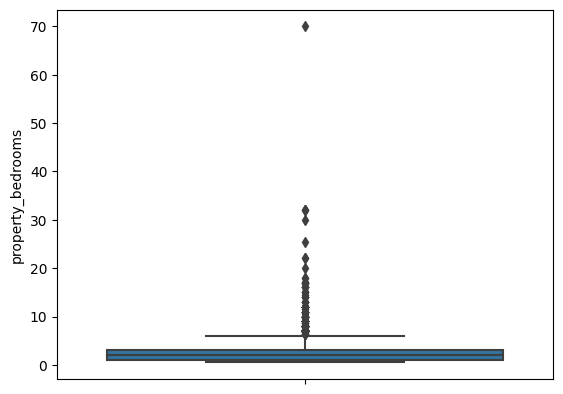

In [44]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

 Analizamos property_surface_total

In [45]:
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers

In [46]:
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
1140            3.8069             2.6260              10500.0000   
1932           22.4970            17.1763             186902.4938   
33017           1.0000             1.0000               4428.0000   
34123           4.0000             3.0000               5000.0000   
35536           1.0000             0.5369               3660.0000   
72316           2.0000             1.0000              61130.0000   
72521           2.0000             1.0000              33800.0000   
84073           1.0000             0.6679              36000.0000   
94789           2.0000             1.0000               5312.0000   
104177          1.0000             1.0000               3623.0000   
106598          2.0000             1.0000              56740.0000   
117835          2.0000             1.0000              43086.0000   
118019          1.0000             1.0000               4100.0000   
126869          1.0000             0.6477              31000.0000   
129214          5.0000             3.0000             137000.0000   
149946          3.0000             2.0000               5736.0000   
219021          4.0000             3.0000              72060.0000   
233699          2.0000             1.0000               4224.0000   
237392          4.0000             3.0000              20041.0000   
263945          3.0000             2.0000               9121.0000   
264624          5.0000             4.0000              14744.0000   
272412          1.0000             0.5369               3660.0000   
275253          1.0000             0.6477              31000.0000   
293109          3.0000             2.0000               5239.0000   
300394          1.0000             0.6477              31000.0000   
304492          1.0000             0.6477              31000.0000   
311702          2.0000             1.0000               3939.0000   
313745          6.0000             2.0000               8988.0000   
314541          1.0000             0.5488               5741.0000   
324150          2.0000             1.0000               4053.0000   
324541          4.0000             3.0000              20041.0000   
352883          1.0000             0.6632              29064.0000   
353009          1.0000             0.6477              31000.0000   
362741          1.0000             0.6477              31000.0000   
370917          4.0000             3.0000              42110.0000   
370918          4.0000             3.0000              42110.0000   
370919          5.0000             4.0000              42110.0000   
370920          5.0000             4.0000              42110.0000   
370922          5.0000             4.0000              42110.0000   
370932          4.0000             3.0000              42110.0000   
372779          4.0000             3.0000             100068.0000   
398069          2.0000             1.0000               6470.0000   
400155          2.0000             1.0000               4632.0000   
405272          4.0000             3.0000               8306.0000   
405324          4.0000             3.0000             123000.0000   
442647          3.0000             2.0000               6836.0000   
449755          2.0000             1.0000               4112.0000   
459588          3.0000             2.0000               6609.0000   
459841          3.0000             2.0000               7153.0000   
459842          3.0000             2.0000               8136.0000   
459847          4.0000             3.0000              18096.0000   
459849          3.0000             2.0000               7720.0000   

        property_surface_covered  property_price    z_rooms   zm_rooms  \
1140                  10500.0000       9900000.0   0.683639   0.544254   
1932                 217000.0000        250000.0  13.780937  13.150726   
33017                    31.0000         58552.0  -1.283328  -1.349000   
34123                   109.0000        418000.0   0.8

Grafico

<AxesSubplot: ylabel='property_surface_total'>

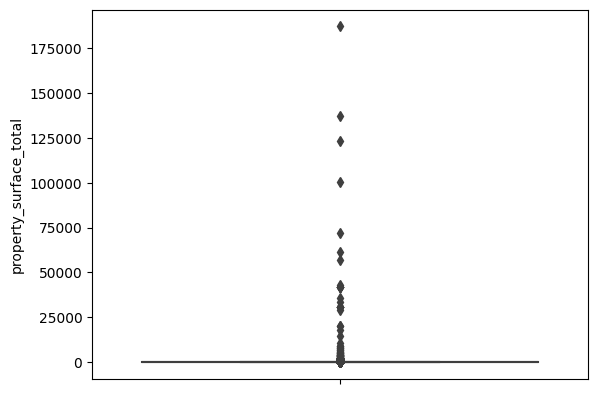

In [47]:
sns.boxplot(y=ds_atipicos.property_surface_total)

 Analizamos property_surface_covered

In [48]:
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)


Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers

In [49]:
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
1140            3.8069             2.6260              10500.0000   
1932           22.4970            17.1763             186902.4938   
72316           2.0000             1.0000              61130.0000   
72521           2.0000             1.0000              33800.0000   
85725           5.0000             4.0000               3197.0000   
94789           2.0000             1.0000               5312.0000   
104177          1.0000             1.0000               3623.0000   
106598          2.0000             1.0000              56740.0000   
117835          2.0000             1.0000              43086.0000   
187888          2.0000             1.0000               3425.0000   
199905          4.0000             2.7834                 83.0000   
233699          2.0000             1.0000               4224.0000   
264624          5.0000             4.0000              14744.0000   
293109          3.0000             2.0000               5239.0000   
311702          2.0000             1.0000               3939.0000   
313745          6.0000             2.0000               8988.0000   
314541          1.0000             0.5488               5741.0000   
352883          1.0000             0.6632              29064.0000   
354376          3.0000             2.0000                 41.0000   
372779          4.0000             3.0000             100068.0000   
398069          2.0000             1.0000               6470.0000   
405272          4.0000             3.0000               8306.0000   
405324          4.0000             3.0000             123000.0000   
459841          3.0000             2.0000               7153.0000   
459842          3.0000             2.0000               8136.0000   
459847          4.0000             3.0000              18096.0000   
459849          3.0000             2.0000               7720.0000   

        property_surface_covered  property_price    z_rooms   zm_rooms  \
1140                  10500.0000       9900000.0   0.683639   0.544254   
1932                 217000.0000        250000.0  13.780937  13.150726   
72316                 53030.0000        225000.0  -0.582566  -0.674500   
72521                 31670.0000         66000.0  -0.582566  -0.674500   
85725                  3367.0000      12000000.0   1.519717   1.349000   
94789                  4809.0000        145000.0  -0.582566  -0.674500   
104177                 3615.0000        110000.0  -1.283328  -1.349000   
106598                52540.0000        175000.0  -0.582566  -0.674500   
117835                40038.0000        114000.0  -0.582566  -0.674500   
187888                 3425.0000         75000.0  -0.582566  -0.674500   
199905                83000.0000        155000.0   0.818956   0.674500   
233699                 4224.0000        100000.0  -0.582566  -0.674500   
264624                13717.0000        330000.0   1.519717   1.349000   
293109                 3501.0872        119000.0   0.118195   0.000000   
311702                 3939.0000         64000.0  -0.582566  -0.674500   
313745                 7454.0000        125000.0   2.220479   2.023500   
314541                 4276.0000         85144.0  -1.283328  -1.349000   
352883                29064.0000         87400.0  -1.283328  -1.349000   
354376                 3837.0000         83000.0   0.118195   0.000000   
372779               100051.0000        420000.0   0.818956   0.674500   
398069                 4664.0000        149900.0  -0.582566  -0.674500   
405272                 7755.0000        129000.0   0.818956   0.674500   
405324               123000.0000        165000.0   0.818956   0.674500   
459841                 7153.0000        177807.0   0.118195   0.000000   
459842                 6472.0000        203550.0   0.118195   0.000000   
459847                 8568.0000        324558.0   0.818956   0.674500   
459849                 5970.0000        167894.0   0.118195   0.000000   

  

Grafico

<AxesSubplot: ylabel='property_surface_covered'>

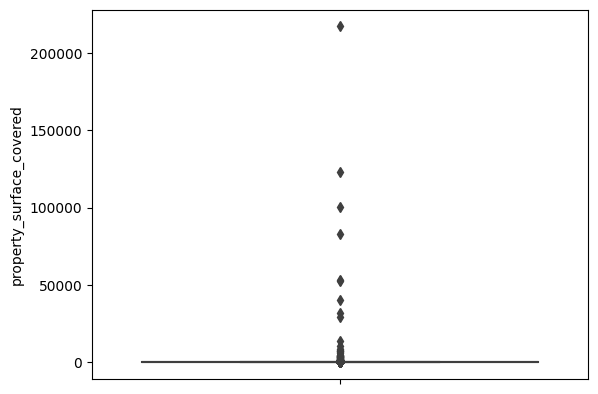

In [50]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

Analizamos property_price

In [51]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
ds_atipicos['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers

In [52]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

property_rooms  property_bedrooms  property_surface_total  \
410              5.201                4.0                   400.0   
411              5.201                4.0                   400.0   
438              4.000                3.0                   282.0   
448              5.000                4.0                   304.0   
629              4.000                3.0                   214.0   
...                ...                ...                     ...   
459724           8.000                3.0                   285.0   
459729           6.000                3.0                   271.0   
459755           8.000                5.0                   431.0   
459764           8.000                4.0                   383.0   
459997           4.000                2.0                   315.0   

        property_surface_covered  property_price   z_rooms  zm_rooms  \
410                     316.9845       2700000.0  1.660570  1.484574   
411                     316.9845       2700000.0  1.660570  1.484574   
438                     256.0000       2250000.0  0.818956  0.674500   
448                     294.0000       1200000.0  1.519717  1.349000   
629                     196.0000       1200000.0  0.818956  0.674500   
...                          ...             ...       ...       ...   
459724                  272.0000       1250000.0  3.622001  3.372500   
459729                  265.0000       1250000.0  2.220479  2.023500   
459755                  415.0000       2800000.0  3.622001  3.372500   
459764                  383.0000       1700000.0  3.622001  3.372500   
459997                  180.0000       2200000.0  0.818956  0.674500   

        z_bedrooms  zm_bedrooms  z_surface_total  z_surface_covered   z_price  \
410       1.842738       1.3490         0.254951           0.229415  7.893604   
411       1.842738       1.3490         0.254951           0.229415  7.893604   
438       0.980853       0.6745         0.151200           0.168449  6.459413   
448       1.842738       1.3490         0.170544           0.206438  3.112967   
629       0.980853       0.6745         0.091411           0.108466  3.112967   
...            ...          ...              ...                ...       ...   
459724    0.980853       0.6745         0.153838           0.184444  3.272321   
459729    0.980853       0.6745         0.141528           0.177446  3.272321   
459755    2.704622       2.0235         0.282208           0.327402  8.212313   
459764    1.842738       1.3490         0.240004           0.295412  4.706512   
459997    0.118968       0.0000         0.180215           0.092471  6.300058   

         zm_price  
410     30.269667  
411     30.269667  
438     24.944667  
448     12.519667  
629     12.519667  
...           ...  
459724  13.111333  
459729  13.111333  
459755  31.453000  
459764  18.436333  
459997  24.353000  

[1538 rows x 13 columns]

Grafico

<AxesSubplot: ylabel='property_price'>

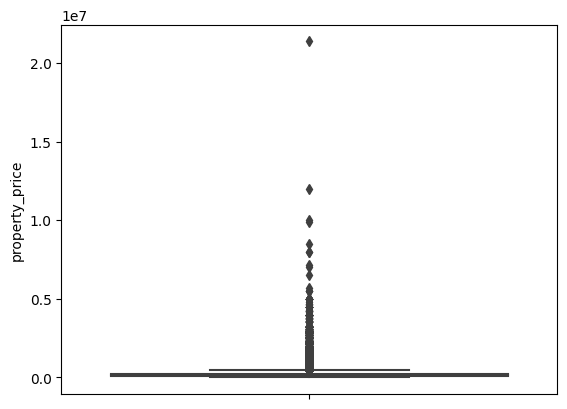

In [53]:
sns.boxplot(y=ds_atipicos.property_price)

### Detectar valores atípicos en los datos en forma multivariada

Utilizamos el metodo de Isolation Forest

In [54]:
from sklearn.ensemble import IsolationForest
#Creo el modelo
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción

In [55]:
ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred= iforest.fit_predict(ds_forest)

C:\Users\Carreño\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Almaceno scores y etiquetas

In [56]:

ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

property_rooms  property_bedrooms  property_surface_total  \
58              10.000               10.0                   394.0   
410              5.201                4.0                   400.0   
411              5.201                4.0                   400.0   
438              4.000                3.0                   282.0   
448              5.000                4.0                   304.0   
...                ...                ...                     ...   
459842           3.000                2.0                  8136.0   
459847           4.000                3.0                 18096.0   
459849           3.000                2.0                  7720.0   
459922          10.000                9.0                   145.0   
459997           4.000                2.0                   315.0   

        property_surface_covered  property_price    scores  outlier_label  
58                      244.0000        500000.0 -0.147300             -1  
410                     316.9845       2700000.0 -0.129843             -1  
411                     316.9845       2700000.0 -0.129843             -1  
438                     256.0000       2250000.0 -0.098962             -1  
448                     294.0000       1200000.0 -0.039906             -1  
...                          ...             ...       ...            ...  
459842                 6472.0000        203550.0 -0.160392             -1  
459847                 8568.0000        324558.0 -0.172535             -1  
459849                 5970.0000        167894.0 -0.160355             -1  
459922                  145.0000        300000.0 -0.099277             -1  
459997                  180.0000       2200000.0 -0.110812             -1  

[4459 rows x 7 columns]

Cuento la cantidad de obs anomalas

In [57]:
ds_forest.outlier_label.value_counts()

 1    84721
-1     4459
Name: outlier_label, dtype: int64

Graficos de valores atipicos relacionando las columnas del dataset

#### property_price vs property_rooms

In [58]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión price vs rooms')
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1500x1500 with 0 Axes>

#### property_bedrooms vs property_rooms

In [61]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_bedrooms'],ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión bedrooms vs rooms')
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1500x1500 with 0 Axes>

#### property_price vs property_surface_covered

In [62]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1500x1500 with 0 Axes>

#### property_price vs property_surface_total

In [63]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1500x1500 with 0 Axes>

### Características y tratamientos de los datos atípicos detectados.

Con los analisis univariados y multivariados que analizamos, concluimos que la mayoria de los datos atipicos los encontramos en valores relacionados con las variables "property_bedrooms", "property_rooms" y "property_price".

Luego de los distintos análisis del dataset pudimos obvservar que al aplicar el método univariado encontramos aquellos outliers con valores extremos en relación a cada columna en particular. En cambio, al implementar el modelo de Isolation Forest para valores atípicos multivariados obtuvimos otras muestras a tener en cuenta como outliers para un mejor tratamiento de los mismos.
Decidimos eliminar solo aquellos valores atipicos, que encontramos en el analisis multivariado y univariado de "property_bedrooms", "property_rooms" y "property_price". En cuanto al analisis de "property_surface_covered" y "property_surface_total" decidimos eliminar todos los valores atipicos obtenidos con el modelo z-score 

Eliminacion de valores atipicos detectados en forma univariada de surface_total && surface_covered

In [64]:
indice_surface_total = ds_atipicos[ds_atipicos['z_surface_total'] > 3 ].index.to_list()
indice_surface_covered = ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ].index.to_list()
indice_a_eliminar_directo = indice_surface_total + indice_surface_covered
ds_atipicos = ds_atipicos.drop(index=indice_a_eliminar_directo)

Eliminacion de valores atipicos coincidentes en ambos metodos

In [65]:
from collections import OrderedDict
from iteration_utilities import duplicates # hay que instalar iteration_utilities "pip install iteration_utilities"
from iteration_utilities import unique_everseen
indice_price = ds_atipicos[ds_atipicos['z_price'] > 3 ].index.to_list()
indice_bedrooms = ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ].index.to_list()
indice_rooms = ds_atipicos[ds_atipicos['z_rooms'] > 3 ].index.to_list()
indice_multi_variable = ds_forest[ds_forest.outlier_label==-1].index.to_list()
indice_a_eliminar = indice_price + indice_bedrooms + indice_rooms
indice_a_eliminar = list(OrderedDict.fromkeys(indice_a_eliminar))
indice_a_eliminar = indice_a_eliminar + indice_multi_variable
a = list(unique_everseen(duplicates(indice_a_eliminar)))
ds_atipicos = ds_atipicos.drop(index=a)
ds_atipicos_copia = ds_atipicos_copia.drop(index = a)

ModuleNotFoundError: No module named 'iteration_utilities'

### Analizar la relación entre el precio de venta y los metros de superficie

volvemos a hacer el analisis despues de la depuracion

In [66]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción

In [67]:

ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred= iforest.fit_predict(ds_forest)

C:\Users\Carreño\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [68]:
ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

property_rooms  property_bedrooms  property_surface_total  \
58              10.000               10.0                   394.0   
410              5.201                4.0                   400.0   
411              5.201                4.0                   400.0   
438              4.000                3.0                   282.0   
448              5.000                4.0                   304.0   
...                ...                ...                     ...   
459767           6.000                3.0                   230.0   
459789           7.000                3.0                   228.0   
459813           6.000                5.0                   143.0   
459922          10.000                9.0                   145.0   
459997           4.000                2.0                   315.0   

        property_surface_covered  property_price    scores  outlier_label  
58                      244.0000        500000.0 -0.151678             -1  
410                     316.9845       2700000.0 -0.114153             -1  
411                     316.9845       2700000.0 -0.114153             -1  
438                     256.0000       2250000.0 -0.087420             -1  
448                     294.0000       1200000.0 -0.058565             -1  
...                          ...             ...       ...            ...  
459767                  226.0000        690000.0 -0.006666             -1  
459789                  228.0000        610000.0 -0.030675             -1  
459813                  143.0000        198000.0 -0.006941             -1  
459922                  145.0000        300000.0 -0.110586             -1  
459997                  180.0000       2200000.0 -0.102082             -1  

[4457 rows x 7 columns]

cantidad de obs. anómalas

In [69]:
ds_forest.outlier_label.value_counts()

 1    84667
-1     4457
Name: outlier_label, dtype: int64

Grafico dispersograma

In [70]:
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1500x1500 with 0 Axes>

Los outliers en casos multivariados como los que analizamos previamente, pueden provocar un efecto de enmascaramietno que se produce cuando un grupo de outliers esconden a otros. Es decir, los outliers enmascarados se haran visibles cuando se eliminen los outliers que los esconden.
En nuestro caso, observamos como al eliminar la primer tanda de valores atipicos y realizar el analisis nuevamente, encontramos nuevos outliers.

# Reduccion De La Dimensionalidad

In [202]:
#Creamos el dataset que será utilizado para la reducción y uliminamos todas las filas con columnas vacías
ds_prop_reducido = ds_atipicos_copia.copy()
ds_prop_reducido = ds_prop_reducido.dropna()

Comenzamos eliminando las variables que ya sabemos no tienen influencia en el precio

In [203]:
variables_eliminadas = ["start_date", "end_date", "created_on", "property_title", "geometry"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud  longitud         place_l2 place_l3 operation property_type  \
42 -34.6373  -58.3611  Capital Federal     Boca     Venta  Departamento   
43 -34.6286  -58.3619  Capital Federal     Boca     Venta  Departamento   
49 -34.6100  -58.4019  Capital Federal     Once     Venta  Departamento   
51 -34.6316  -58.4168  Capital Federal    Boedo     Venta            PH   
53 -34.6239  -58.4127  Capital Federal    Boedo     Venta            PH   

    property_rooms  property_bedrooms  property_surface_total  \
42             3.0                2.0                 58.0000   
43             4.0                3.0                 70.0000   
49             4.0                2.0                133.7565   
51             4.0                2.0                107.0934   
53             2.0                1.0                 61.0000   

    property_surface_covered  property_price property_currency  
42                      55.0         82900.0               USD  
43                      70.0         99000.0               USD  
49                     104.0        146000.0               USD  
51                      73.0        250000.0               USD  
53                      46.0        100000.0               USD

Analizamos Correlaciones

In [204]:
ds_prop_reducido.corr()

C:\Users\Carreño\AppData\Local\Temp\ipykernel_6088\2354189161.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_prop_reducido.corr()


latitud  longitud  property_rooms  \
latitud                   1.000000 -0.138258       -0.035905   
longitud                 -0.138258  1.000000        0.014211   
property_rooms           -0.035905  0.014211        1.000000   
property_bedrooms        -0.040714  0.008719        0.899924   
property_surface_total    0.003881  0.002089        0.082755   
property_surface_covered  0.002326  0.003512        0.086990   
property_price            0.148436  0.123036        0.474040   

                          property_bedrooms  property_surface_total  \
latitud                           -0.040714                0.003881   
longitud                           0.008719                0.002089   
property_rooms                     0.899924                0.082755   
property_bedrooms                  1.000000                0.078939   
property_surface_total             0.078939                1.000000   
property_surface_covered           0.081954                0.757865   
property_price                     0.421329                0.069887   

                          property_surface_covered  property_price  
latitud                                   0.002326        0.148436  
longitud                                  0.003512        0.123036  
property_rooms                            0.086990        0.474040  
property_bedrooms                         0.081954        0.421329  
property_surface_total                    0.757865        0.069887  
property_surface_covered                  1.000000        0.055103  
property_price                            0.055103        1.000000

Se puede ver la fuerte correlación entre 'property_rooms' y property_bedrooms'. Al analizarla, vemos que 'property_rooms' son la cantidad de ambientes del inmueble (habitaciones más el comedor), mientras 'property_bedrooms' hace referencia a la  cantidad de dormitorios. Un dormitorio cuenta como habitacion, por lo tanto si aumenta 'property_bedrooms', aumentará 'property_rooms'. 
Por lo tanto es claro que hay una posible reducción. Si vamos a la pagina 'https://www.properati.com.ar/data/', el esquema de avisos nos informa que 'property_bedrooms' no es útil para los avisos en Argentina. Asi que elegimos eliminar del dataset 'property_bedrooms'.

Lo mismo sucede con las variables 'property_surface_total' y 'property_surace_covered'. Están fuertemente correlacionadas ya que si aumente property_surface_covered', aumenta 'property_surface_total'. Por lo tanto eliminamos 'property_surface_covered'.

In [205]:
variables_eliminadas = ["property_bedrooms", "property_surface_covered"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud  longitud         place_l2 place_l3 operation property_type  \
42 -34.6373  -58.3611  Capital Federal     Boca     Venta  Departamento   
43 -34.6286  -58.3619  Capital Federal     Boca     Venta  Departamento   
49 -34.6100  -58.4019  Capital Federal     Once     Venta  Departamento   
51 -34.6316  -58.4168  Capital Federal    Boedo     Venta            PH   
53 -34.6239  -58.4127  Capital Federal    Boedo     Venta            PH   

    property_rooms  property_surface_total  property_price property_currency  
42             3.0                 58.0000         82900.0               USD  
43             4.0                 70.0000         99000.0               USD  
49             4.0                133.7565        146000.0               USD  
51             4.0                107.0934        250000.0               USD  
53             2.0                 61.0000        100000.0               USD

Analizamos la varianza de atributos

Debido a la filtracion del datset originales, vemos que las variables 'place_l2', 'property_currency' y 'operation' tienen todas el mismo valor. Como son todas iguales, no van a tener peso a la hora de modificar el precio, por lo tanto las eliminamos

In [206]:
variables_eliminadas = ["place_l2", "property_currency", "operation"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud  longitud place_l3 property_type  property_rooms  \
42 -34.6373  -58.3611     Boca  Departamento             3.0   
43 -34.6286  -58.3619     Boca  Departamento             4.0   
49 -34.6100  -58.4019     Once  Departamento             4.0   
51 -34.6316  -58.4168    Boedo            PH             4.0   
53 -34.6239  -58.4127    Boedo            PH             2.0   

    property_surface_total  property_price  
42                 58.0000         82900.0  
43                 70.0000         99000.0  
49                133.7565        146000.0  
51                107.0934        250000.0  
53                 61.0000        100000.0

Analizamos la importancia de los atributos

In [207]:
#One Hot Encoding para variables categoricas
from sklearn.metrics import mean_squared_error


variables_reemplazadas = ["property_type", "place_l3"]
ds_prop_arbol = pd.get_dummies(ds_prop_reducido, columns=variables_reemplazadas, drop_first=True)

#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ['property_price']
ds_prop_filtrado_x = ds_prop_arbol.drop(variables_eliminadas, axis='columns', inplace=False)

scaler = MinMaxScaler()
ds_prop_filtrado_x["property_surface_total"] = scaler.fit_transform(ds_prop_filtrado_x["property_surface_total"].to_frame())
ds_prop_filtrado_x["longitud"] = scaler.fit_transform(ds_prop_filtrado_x["longitud"].to_frame())
ds_prop_filtrado_x["latitud"] = scaler.fit_transform(ds_prop_filtrado_x["latitud"].to_frame())

#Creo dataset con la variable target

ds_prop_filtrado_y = ds_prop_arbol['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x, 
                                                    ds_prop_filtrado_y, 
                                                    test_size=0.2, #proporción 90/10 
                                                    random_state=9) #semilla

tree_model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=20, min_samples_leaf=2)

#Entrenamos el modelo
model = tree_model.fit(X=x_train, y=y_train)
y_pred = model.predict(x_test)

#Calculamos las métricas en el conjunto de evaluación
rmse=mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: " + str(rmse))

RMSE: 126048.5439019186


In [208]:
#Importancia de los atributos de mayor a menor
sorted(list(zip(ds_prop_filtrado_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('property_surface_total', 0.31792666103833406),
 ('latitud', 0.3061846277150775),
 ('longitud', 0.281509667427011),
 ('property_rooms', 0.038214535881744026),
 ('property_type_Departamento', 0.00866418403573727),
 ('place_l3_Puerto Madero', 0.006513087155965694),
 ('place_l3_Caballito', 0.006415637654736308),
 ('property_type_PH', 0.005884866328508347),
 ('place_l3_Palermo', 0.00276500792874918),
 ('place_l3_Villa Urquiza', 0.0020350333661748226),
 ('place_l3_Recoleta', 0.001544928370523391),
 ('place_l3_Almagro', 0.0014370448929413129),
 ('place_l3_Barrio Norte', 0.0014184412729302876),
 ('place_l3_Balvanera', 0.0013668408281124853),
 ('place_l3_Flores', 0.00129179879168607),
 ('place_l3_Belgrano', 0.0012268142597401668),
 ('place_l3_Villa Crespo', 0.0010349493383293611),
 ('place_l3_Villa Devoto', 0.0009336508712900648),
 ('place_l3_Villa del Parque', 0.0008384260119663156),
 ('place_l3_San Cristobal', 0.0008338019244451784),
 ('place_l3_San Nicolás', 0.0008125731826463058),
 ('pla

Vemos como las variable 'place_l3' y 'property_type' tienen muy poca importancia en el arbol de decision. Por lo tanto, las eliminamos

In [209]:
variables_eliminadas = ["place_l3", "property_type"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

latitud  longitud  property_rooms  property_surface_total  property_price
42 -34.6373  -58.3611             3.0                 58.0000         82900.0
43 -34.6286  -58.3619             4.0                 70.0000         99000.0
49 -34.6100  -58.4019             4.0                133.7565        146000.0
51 -34.6316  -58.4168             4.0                107.0934        250000.0
53 -34.6239  -58.4127             2.0                 61.0000        100000.0

Hacemos PCA para analizar posibles reducciones

In [210]:
ds_prop_reducido_pca = ds_prop_reducido.copy()

columnas_elegidas = ["latitud", "longitud", "property_rooms", "property_surface_total"]

x = ds_prop_reducido_pca.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=4) 
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4'])


print("Variabilidad explicada por cada componente:"  + str(pca.explained_variance_ratio_))

Variabilidad explicada por cada componente:[0.28747808 0.26860519 0.22940289 0.21451384]


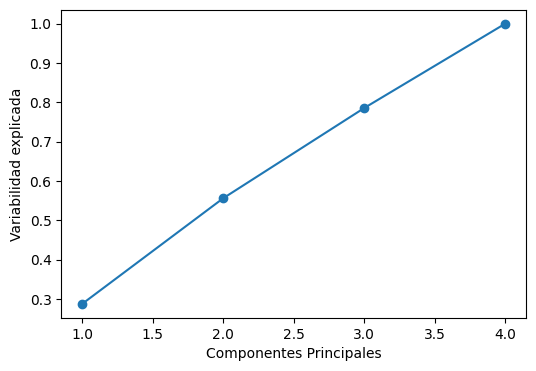

In [211]:
variabilidad_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, variabilidad_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

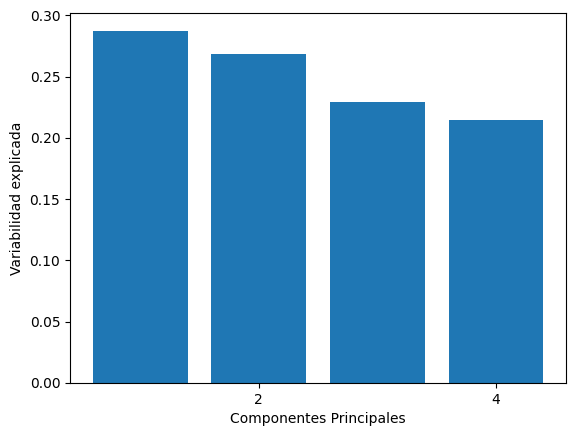

In [212]:
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales

plt.locator_params('x', nbins = 4)
plt.bar(list_x, variabilidad_explicada)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Vemos como los cuatro componentes tienen una canidad significativa de variablididad explicada. Por lo tanto aplicarle PCA al dataset resultaría en una perdida de información elevada. De esta forma concluimos que no es beneficioso realizar PCA

# Agrupamiento


## Clustering

In [213]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

Sacamos columnas que no se utilizan

In [214]:
ds_kmeans = ds_atipicos_copia.copy()
columnas = ["start_date", "end_date", "created_on", "place_l2", "place_l3", "operation", "property_currency", "property_title", "latitud", "longitud"]
ds_kmeans.drop(columns = columnas, inplace = True)

Aplicamos dummies para property_type

In [215]:
ds_kmeans = pd.get_dummies(ds_kmeans, columns=['property_type'])
ds_kmeans

property_rooms  property_bedrooms  property_surface_total  \
42                 3.0                2.0                 58.0000   
43                 4.0                3.0                 70.0000   
49                 4.0                2.0                133.7565   
51                 4.0                2.0                107.0934   
53                 2.0                1.0                 61.0000   
...                ...                ...                     ...   
460072             4.0                3.0                130.0000   
460073             3.0                2.0                 68.0000   
460074             1.0                1.0                 51.0000   
460075             1.0                1.0                 37.0000   
460090             2.0                1.0                 84.0000   

        property_surface_covered  property_price                     geometry  \
42                          55.0         82900.0  POINT (-58.36110 -34.63730)   
43                          70.0         99000.0  POINT (-58.36190 -34.62860)   
49                         104.0        146000.0  POINT (-58.40190 -34.61000)   
51                          73.0        250000.0  POINT (-58.41680 -34.63160)   
53                          46.0        100000.0  POINT (-58.41270 -34.62390)   
...                          ...             ...                          ...   
460072                     100.0        220000.0  POINT (-58.48980 -34.60320)   
460073                      60.0        161000.0  POINT (-58.48280 -34.61410)   
460074                      30.0         75500.0  POINT (-58.47910 -34.61420)   
460075                      31.0         74500.0  POINT (-58.47910 -34.61420)   
460090                      84.0        135000.0  POINT (-58.37340 -34.59980)   

        property_type_Casa  property_type_Departamento  property_type_PH  
42                       0                           1                 0  
43                       0                           1                 0  
49                       0                           1                 0  
51                       0                           0                 1  
53                       0                           0                 1  
...                    ...                         ...               ...  
460072                   0                           1                 0  
460073                   0                           1                 0  
460074                   0                           1                 0  
460075                   0                           1                 0  
460090                   0                           1                 0  

[89180 rows x 9 columns]

Aplicamos MinMaxScaler para variables numericas

In [216]:
scaler = MinMaxScaler()
ds_kmeans["property_surface_total"] = scaler.fit_transform(ds_kmeans["property_surface_total"].to_frame())
ds_kmeans["property_surface_covered"] = scaler.fit_transform(ds_kmeans["property_surface_covered"].to_frame())
ds_kmeans["property_price"] = scaler.fit_transform(ds_kmeans["property_price"].to_frame())
ds_kmeans["property_bedrooms"] = scaler.fit_transform(ds_kmeans["property_bedrooms"].to_frame())
ds_kmeans["property_rooms"] = scaler.fit_transform(ds_kmeans["property_rooms"].to_frame())
ds_kmeans

property_rooms  property_bedrooms  property_surface_total  \
42            0.051282           0.021272                0.000257   
43            0.076923           0.035665                0.000321   
49            0.076923           0.021272                0.000662   
51            0.076923           0.021272                0.000520   
53            0.025641           0.006878                0.000273   
...                ...                ...                     ...   
460072        0.076923           0.035665                0.000642   
460073        0.051282           0.021272                0.000310   
460074        0.000000           0.006878                0.000219   
460075        0.000000           0.006878                0.000144   
460090        0.025641           0.006878                0.000396   

        property_surface_covered  property_price                     geometry  \
42                      0.000253        0.003641  POINT (-58.36110 -34.63730)   
43                      0.000323        0.004394  POINT (-58.36190 -34.62860)   
49                      0.000479        0.006590  POINT (-58.40190 -34.61000)   
51                      0.000336        0.011451  POINT (-58.41680 -34.63160)   
53                      0.000212        0.004440  POINT (-58.41270 -34.62390)   
...                          ...             ...                          ...   
460072                  0.000461        0.010049  POINT (-58.48980 -34.60320)   
460073                  0.000276        0.007291  POINT (-58.48280 -34.61410)   
460074                  0.000138        0.003295  POINT (-58.47910 -34.61420)   
460075                  0.000143        0.003248  POINT (-58.47910 -34.61420)   
460090                  0.000387        0.006076  POINT (-58.37340 -34.59980)   

        property_type_Casa  property_type_Departamento  property_type_PH  
42                       0                           1                 0  
43                       0                           1                 0  
49                       0                           1                 0  
51                       0                           0                 1  
53                       0                           0                 1  
...                    ...                         ...               ...  
460072                   0                           1                 0  
460073                   0                           1                 0  
460074                   0                           1                 0  
460075                   0                           1                 0  
460090                   0                           1                 0  

[89180 rows x 9 columns]

### Estimamos la cantidad apropiada de grupos que se deben formar. 

In [217]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

TypeError: float() argument must be a string or a number, not 'Point'

En este caso son 3 

Aplicamos k-means con la cantidad de clusters indicados por la regla del codo

In [ ]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(ds_kmeans)

TypeError: float() argument must be a string or a number, not 'Point'

In [ ]:
clusters = kmeans.predict(ds_kmeans)
ds_kmeans["cluster"] = clusters

TypeError: float() argument must be a string or a number, not 'Point'

### Silhouette

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_kmeans.drop(columns=["cluster"]))
plt.show()

ModuleNotFoundError: No module named 'yellowbrick'

Como se observa en el grafico, tenemos 3 grupos sin mediciones que esten mas cerca de otro cluster que del que pertenecen.

### Analisis por grupo


In [ ]:
ds_kmeans.shape

(89180, 9)

Como se puede observar, los grupos fueron creados en funcion de la caracteristica de property_type.
El cluster 0 es propiedad del tipo Departamento, el cluster 1  propiedad del tipo PH y el cluster 2 porpiedad de tipo casa

In [ ]:
ds_kmeans["property_type"] = ds_atipicos_copia["property_type"]
pd.crosstab(ds_kmeans['cluster'],ds_kmeans['property_type'])

KeyError: 'cluster'

### Mapa

Delimitacionn de capital federal 

In [ ]:
ds_mapa_point = geopandas.GeoDataFrame(ds_atipicos_copia, geometry=geopandas.points_from_xy(ds_atipicos_copia.longitud, ds_atipicos_copia.latitud))
ds_mapa_capital = geopandas.read_file("barrios_2/barrios-polygon.shp")

Text(0.5, 1.0, 'Mapa de propiedades en CABA')

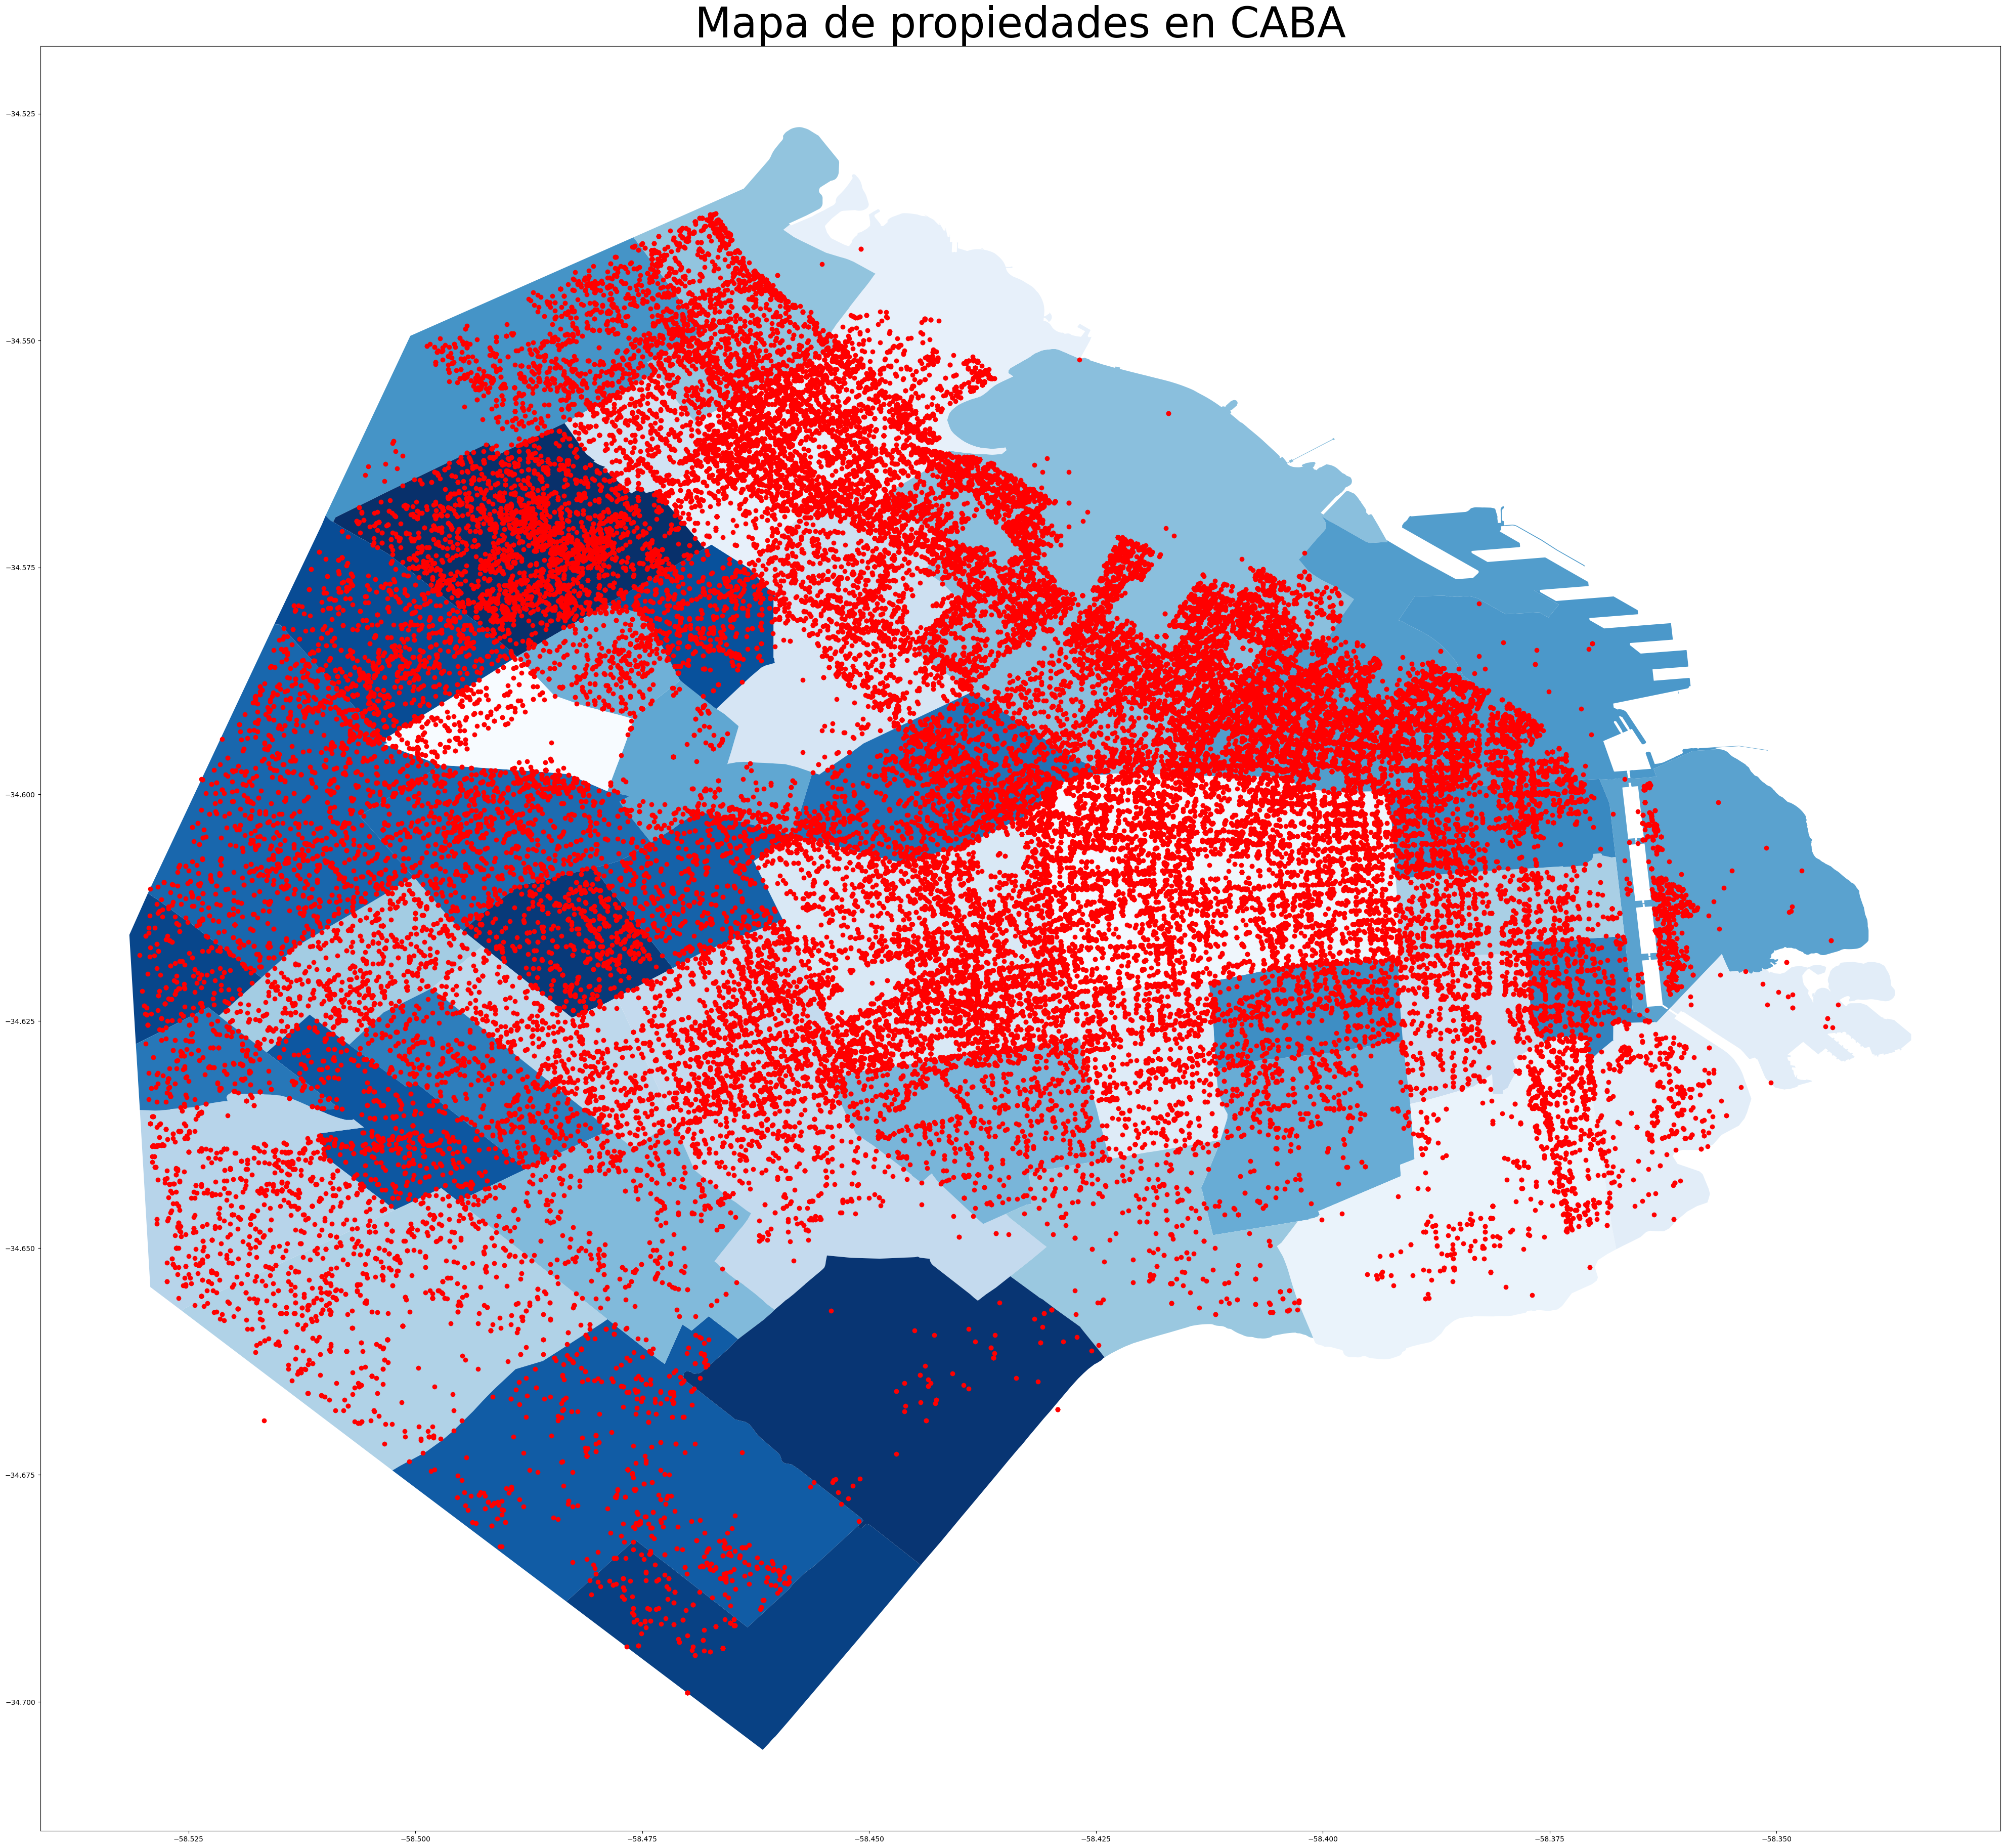

In [ ]:
fig,ax = plt.subplots(figsize = (50,50))
ds_mapa_capital.plot(ax = ax, column = "BARRIO", cmap = "Blues")
ds_mapa_point.plot(ax = ax, color = "red")
ax.set_title("Mapa de propiedades en CABA", fontdict = {"fontsize" : "60"})

# XGBoost

In [243]:
ds_prop_XGBoost = ds_atipicos_copia.copy()
ds_prop_XGBoost = ds_prop_XGBoost.dropna()

In [244]:
#Eliminamos las features sin importancia
variables_eliminadas = ["start_date", "end_date", "created_on", "property_title", "place_l2", "property_currency", "operation", "geometry"]
ds_prop_XGBoost = ds_prop_XGBoost.drop(variables_eliminadas, axis='columns', inplace=False)

Realizaos ingenieria de caracteristicas

In [245]:
#One Hot Encoding para variables categoricas

variables_reemplazadas = ["property_type", "place_l3"]
ds_prop_arbol_XGBoost = pd.get_dummies(ds_prop_XGBoost, columns=variables_reemplazadas, drop_first=True)

#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ["property_price"]
ds_prop_filtrado_x = ds_prop_arbol_XGBoost.drop(variables_eliminadas, axis='columns', inplace=False)

#Esalamos las variables para que no tengan mayor peso
scaler = MinMaxScaler()
ds_prop_filtrado_x["property_surface_total"] = scaler.fit_transform(ds_prop_filtrado_x["property_surface_total"].to_frame())
ds_prop_filtrado_x["longitud"] = scaler.fit_transform(ds_prop_filtrado_x["longitud"].to_frame())
ds_prop_filtrado_x["latitud"] = scaler.fit_transform(ds_prop_filtrado_x["latitud"].to_frame())

#Creo dataset con la variable target
ds_prop_filtrado_y = ds_prop_arbol_XGBoost['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x,
                                                    ds_prop_filtrado_y,
                                                    test_size=0.2,
                                                    random_state=6)



Buscamos los mejores hiperparametros usando Random CV. Usamos Random CV para hallar los hiperparametros que optimizen el MSE, ya que es la medida que nos interesa a al hora de hacer regresion. Queremos calcular el error medio de las predicciones

In [246]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


#Cantidad de combinaciones que quiero porbar
n=5

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(3,9)),
               'random_state':list(range(0,6))}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
#kfoldcv = StratifiedKFold(n_splits=folds)

#Regresor
xgb_model_rd_search = xgb.XGBRegressor()

#Metrica que quiero optimizar MSE
scorer_fn = make_scorer(sklearn.metrics.mean_squared_error)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_model_rd_search,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              n_iter=n, cv=folds) 

#GridSearch CV
#gridcv = GridSearchCV(estimator=xgb_model_rd_search,
#                      param_grid=params_grid,
#                      scoring=scorer_fn,
#                      return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train)



[22:14:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:14:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:14:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "criterio

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5,
                   param_distributions={'ccp_alpha': array([0.    , 0.0125, 0.025 , 0.0375, 0.05  ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'random_state': [0, 1, 2, 3, 4, 5]},
                   scoring=make_scorer(mean_squared_error))

In [247]:
#Mejores hiperparametros
print(randomcv.best_params_)

#Mejor métrica
mse = randomcv.best_score_
print("RMSE en datos de entrnamiento: " + str(np.sqrt(mse)))

{'random_state': 3, 'max_depth': 3, 'criterion': 'entropy', 'ccp_alpha': 0.0}
RMSE en datos de entrnamiento: 164158.80092376142


In [248]:
xgb_model = xgb.XGBRegressor().set_params(**randomcv.best_params_)
xgb_model.fit(x_train, y_train)

[22:17:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None, ccp_alpha=0.0,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             criterion='entropy', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=3, ...)

Medimos que tan precisas fueron las predicciones usando RMSE. La ventaja de usar RMSE en vez de MSE es que el valor de RMSE está en las mismas unidades que la variable target. De esta forma es más fácil dimensionar que tan preciso es el modelo creado

In [258]:
from sklearn.metrics import mean_squared_error


y_pred = xgb_model.predict(x_test)
#MSE 121489.55

rmse = mean_squared_error(y_test, y_pred, squared=False)
#print("MSE: %.2f" % (mse**(1/2.0)))
print("RMSE en datos de test: " + str(rmse))


RMSE en datos de test: 106991.04391314271


Vemos que la performance de entrenamiento y la del conjunto de evaluación es similar. Esto significa que no hay overfitting, es decir, el modelo no se aprende de 'memoria' los datos de entrenamiento y no pierde precision al realizar las predicciones en el conjunto de evaluación. 

In [250]:
#Atributos considerados y su importancia

features = ["latitud", "longitud", "property_rooms", "propperty_bedrooms", "property_surface_total", "property_surface_covered", "property_type_PH", "property_type_Departamento", "place_l3_ALMAGRO"]
feat_imps = xgb_model.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))


property_type_Departamento: 0.0037300565745681524
property_rooms: 0.0124522028490901
property_surface_total: 0.02573106624186039
propperty_bedrooms: 0.03104245662689209
longitud: 0.038643728941679
latitud: 0.05046500638127327
property_surface_covered: 0.19958621263504028
property_type_PH: 0.25418347120285034


Volvemos a hacer las predicciones, pero ahora con el dataset reducido generado en el punto 1d)

In [251]:
ds_prop_XGBoost = ds_prop_reducido.copy()

In [252]:
ds_prop_reducido.head(2)

latitud  longitud  property_rooms  property_surface_total  property_price
42 -34.6373  -58.3611             3.0                    58.0         82900.0
43 -34.6286  -58.3619             4.0                    70.0         99000.0

Realizamos la ingenieria de caracteristicas y division train-test

In [253]:
#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ["property_price"]
ds_prop_filtrado_x = ds_prop_XGBoost.drop(variables_eliminadas, axis='columns', inplace=False)


scaler = MinMaxScaler()
ds_prop_filtrado_x["property_surface_total"] = scaler.fit_transform(ds_prop_filtrado_x["property_surface_total"].to_frame())
ds_prop_filtrado_x["longitud"] = scaler.fit_transform(ds_prop_filtrado_x["longitud"].to_frame())
ds_prop_filtrado_x["latitud"] = scaler.fit_transform(ds_prop_filtrado_x["latitud"].to_frame())

#Creo dataset con la variable target

ds_prop_filtrado_y = ds_prop_XGBoost['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x,
                                                    ds_prop_filtrado_y,
                                                    test_size=0.2,
                                                    random_state=6)

Entrenamos el modelo

In [254]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Medimos que tan precisas fueron las predicciones

In [257]:
y_pred = xgb_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred, squared=False)
print(mse)


106991.04391314271


Vemos como el RMSE del modelo con el datast reducido es similar al RMSE del modelo con el datset sin reducir. Esto nos indica que la reducción de la dimensionalidad realizada en el punto 1d) logró mantener gran parte de la variablidad explicada. A la vez, logró reducir el dataset, haciendolo más pequeño y más eficiente a la hora del analisis del mismo

In [256]:
#Atributos considerados y su importancia

features = ["latitud", "longitud", "property_rooms", "property_surface_total"]
feat_imps = xgb_model.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))


property_rooms: 0.0663771703839302
latitud: 0.17910136282444
longitud: 0.2085556983947754
property_surface_total: 0.5459657311439514
